In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [8]:
path = "/home/edwin/Datasets/competitions/avito-demand-prediction/"

In [10]:
from subprocess import check_output
print(check_output(["ls", f"{path}"]).decode("utf8"))

data
periods_test.csv.zip
periods_train.csv.zip
sample_submission.csv
test_active.csv.zip
test.csv
test.csv.zip
test_jpg.zip
train_active.csv.zip
train.csv
train.csv.zip
train_jpg.zip



In [32]:
train_df = pd.read_csv(f"{path}train.csv", parse_dates=["activation_date"])

In [15]:
train_df.shape

(1503424, 18)

In [16]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


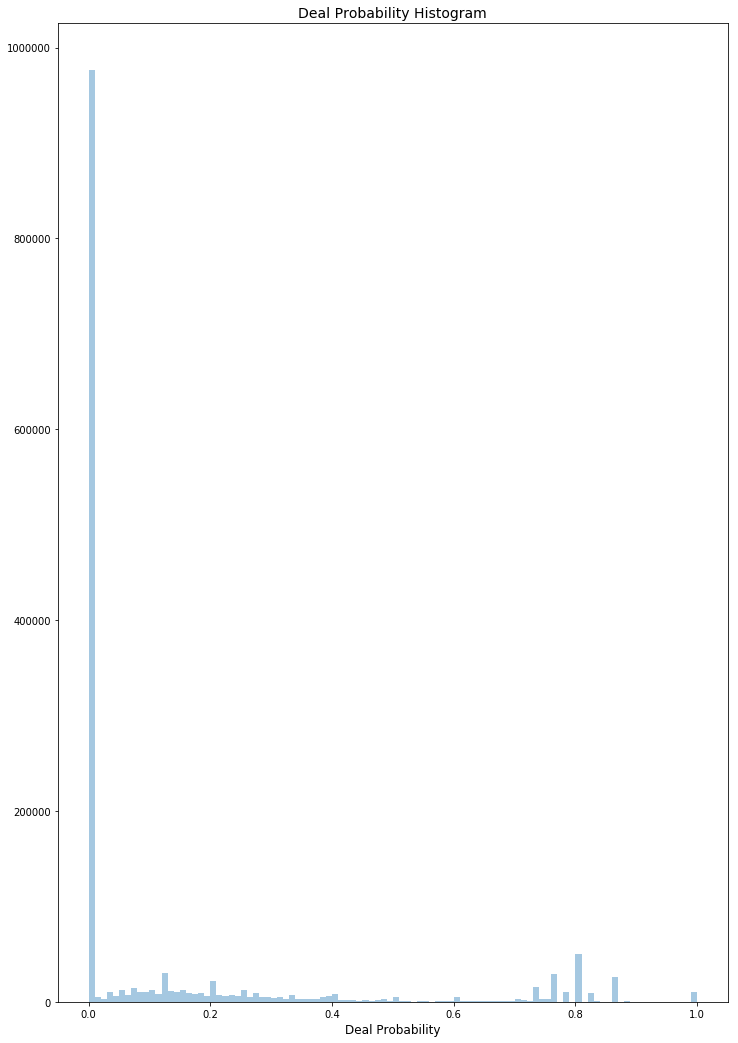

In [18]:
plt.figure(figsize=(12,18))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probability', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

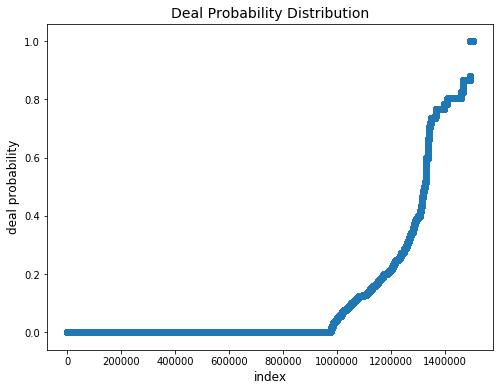

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title('Deal Probability Distribution', fontsize=14)
plt.show()

In [22]:
# fill in missing values
train_df["description"].fillna("NA", inplace=True)

In [25]:
train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))

In [26]:
train_df["desc_nwords"]

0            7
1            7
2           17
3            3
4            4
5            3
6           21
7            4
8            5
9           11
10          11
11           1
12          20
13           7
14           6
15          31
16          61
17           5
18          11
19          43
20          34
21          17
22          19
23           6
24          66
25          32
26           6
27           7
28           9
29           4
          ... 
1503394     27
1503395      4
1503396      4
1503397     13
1503398      8
1503399      5
1503400      1
1503401      3
1503402     64
1503403     15
1503404     18
1503405     10
1503406      8
1503407      1
1503408     39
1503409      5
1503410     17
1503411      1
1503412      6
1503413      8
1503414     30
1503415      8
1503416    115
1503417     34
1503418     14
1503419      1
1503420     34
1503421     27
1503422      6
1503423    145
Name: desc_nwords, Length: 1503424, dtype: int64

In [27]:
train_df["price"]

0              400.0
1             3000.0
2             4000.0
3             2200.0
4            40000.0
5             1300.0
6            11000.0
7              500.0
8              500.0
9              400.0
10           18000.0
11               1.0
12              70.0
13            2500.0
14            5000.0
15             800.0
16          140000.0
17             500.0
18            1000.0
19          100000.0
20         1748000.0
21            2600.0
22          249000.0
23            1300.0
24               NaN
25            1500.0
26            1000.0
27            1500.0
28            1000.0
29             200.0
             ...    
1503394       2000.0
1503395      20000.0
1503396          NaN
1503397        450.0
1503398        500.0
1503399        300.0
1503400        400.0
1503401        250.0
1503402     720000.0
1503403        500.0
1503404    1300000.0
1503405       3000.0
1503406       3000.0
1503407        300.0
1503408    1600000.0
1503409        480.0
1503410      

In [36]:
train_df["price"]

0              400.0
1             3000.0
2             4000.0
3             2200.0
4            40000.0
5             1300.0
6            11000.0
7              500.0
8              500.0
9              400.0
10           18000.0
11               1.0
12              70.0
13            2500.0
14            5000.0
15             800.0
16          140000.0
17             500.0
18            1000.0
19          100000.0
20         1748000.0
21            2600.0
22          249000.0
23            1300.0
24               0.0
25            1500.0
26            1000.0
27            1500.0
28            1000.0
29             200.0
             ...    
1503394       2000.0
1503395      20000.0
1503396          0.0
1503397        450.0
1503398        500.0
1503399        300.0
1503400        400.0
1503401        250.0
1503402     720000.0
1503403        500.0
1503404    1300000.0
1503405       3000.0
1503406       3000.0
1503407        300.0
1503408    1600000.0
1503409        480.0
1503410      

In [37]:
# important variables so far, price, image description

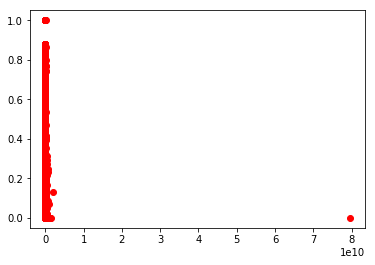

In [47]:
plt.plot(train_df["price"].values, train_df["deal_probability"].values, 'ro')
plt.show()


In [48]:
train_df["deal_probability"].values

array([ 0.12789,  0.     ,  0.43177, ...,  0.39569,  0.     ,  0.     ])

In [49]:
train_df["price"].values

array([  400.,  3000.,  4000., ...,     0.,   350.,  1500.])

/home/edwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



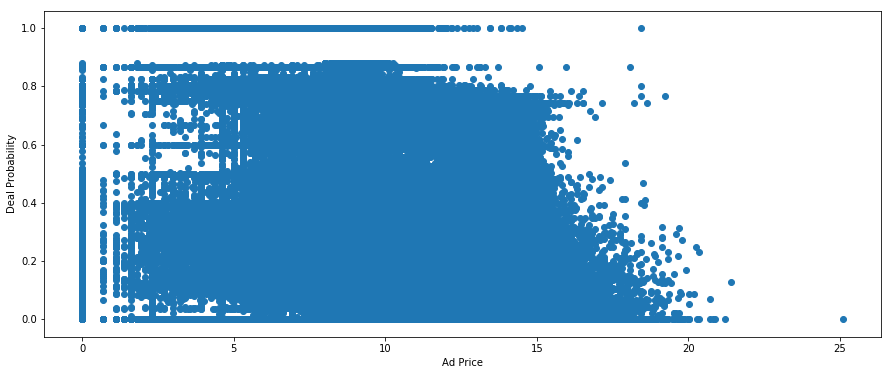

In [53]:
plt.figure(figsize=(15,6))
plt.scatter(np.log(train_df["price"]), train_df["deal_probability"])
plt.xlabel('Ad Price')
plt.ylabel('Deal Probability')
plt.show()

In [59]:
train_df['region'].astype('category').cat.as_ordered()

0             Свердловская область
1                Самарская область
2               Ростовская область
3                        Татарстан
4            Волгоградская область
5                        Татарстан
6            Нижегородская область
7                    Пермский край
8             Оренбургская область
9            Нижегородская область
10             Ханты-Мансийский АО
11               Тюменская область
12            Оренбургская область
13              Ростовская область
14                    Башкортостан
15                       Татарстан
16              Краснодарский край
17           Новосибирская область
18                  Омская область
19            Белгородская область
20           Новосибирская область
21            Свердловская область
22             Челябинская область
23              Ростовская область
24           Нижегородская область
25             Воронежская область
26               Самарская область
27             Кемеровская область
28             Сарат